# Sensors

Sensors let your app know the relationship between a device and the physical world around it. Sensors can tell your app the direction, orientation, and movement of the device. These sensors can help make your game, augmented reality app, or utility app more useful and interactive by providing a unique form of input, such as using the motion of the device to arrange the characters on the screen or to simulate being in a cockpit and using the device as the steering wheel.

A lot of information can be retrive from a Mobile, but I will focus on that metrics that were record for our dataset.

The *Accelerometer* sensor measures G-force values along the X, Y, and Z axes of the device and is great for simple motion-based applications. G-force values include acceleration due to gravity. 

The following diagrams illustrate:

<li>V1 = Vector 1 = Force due to gravity
<li>V2 = Vector 2 = -Z axis of device chassis (points out of back of screen)
<li>Θi = Tilt angle (inclination) = angle between –Z axis of device chassis and gravity vector
</li>

<img src="images/accelerometer2.png">

The *Gyrometer* sensor measures angular velocities along the X, Y, and Z axes. These are very useful in simple motion-based apps that do not concern themselves with device orientation but care about the device rotating at different speeds. Gyrometers can suffer from noise in the data or a constant bias along one or more of the axes. You should query the accelerometer to verify whether the device is moving in order to determine if the gyrometer suffers from a bias, and then compensate accordingly in your app.

<img src="images/gyrometer.png">

The *Inclinometer* sensor specifies the yaw, pitch, and roll values of a device and work best with apps that care about how the device is situated in space. Pitch and roll are derived by taking the accelerometer’s gravity vector and by integrating the data from the gyrometer. Yaw is established from magnetometer and gyrometer (similar to compass heading) data. Inclinometers offer advanced orientation data in an easily digestible and understandable way. Use inclinometers when you need device orientation but do not need to manipulate the sensor data.

<img src="images/inclinometer.png">

# Mobile Sensor Data Set

This dataset we are going to analyse is from [Kaggle](https://www.kaggle.com/). It includes time-series data generated by accelerometer and gyroscope sensors (attitude, gravity, userAcceleration, and rotationRate). It is collected with an iPhone 6s kept in the participant's front pocket using SensingKit which collects information from Core Motion framework on iOS devices. A total of 24 participants in a range of gender, age, weight, and height performed 6 activities in 15 trials in the same environment and conditions: downstairs, upstairs, walking, jogging, sitting, and standing. With this dataset, authors aim to look for personal attributes fingerprints in time-series of sensor data, i.e. attribute-specific patterns that can be used to infer gender or personality of the data subjects in addition to their activities.


For each participant, the study had been commenced by collecting their demographic (age and gender) and physically-related (height and weight) information. Then, they provided them with a dedicated smartphone (iPhone 6) and asked them to store it in their trousers' front pocket during the experiment. All the participant were asked to wear flat shoes. They then asked them to perform 6 different activities (walk downstairs, walk upstairs, sit, stand and jogging) around the [Queen Mary University of London'](https://www.qmul.ac.uk/)s Mile End campus. 

For each trial, the researcher set up the phone and gave it to the current participants, then the researcher stood in a corner. Then, the participant pressed the start button of Crowdsense app and put it in their trousers' front pocket and performed the specified activity. We asked them to do it as natural as possible, like their everyday life. At the end of each trial, they took the phone out of their pocket and pressed the stop button. 

There are 15 trials:

**Long trials:** those with number 1 to 9 with around 2 to 3 minutes duration.<br>
**Short trials:** those with number 11 to 16 that are around 30 seconds to 1 minutes duration.

There are 24 data subjects. The `A_DeviceMotion_data` folder contains time-series collected by both Accelerometer and Gyroscope for all 15 trials. For every trial we have a multivariate time-series. Thus, we have time-series with 12 features: `attitude.roll`, `attitude.pitch`, `attitude.yaw`, `gravity.x`, `gravity.y`, `gravity.z`, `rotationRate.x`, `rotationRate.y`, `rotationRate.z`, `userAcceleration.x`, `userAcceleration.y`, `userAcceleration.z`.

The accelerometer measures the sum of two acceleration vectors: gravity and user acceleration. 

**User acceleration** is the acceleration that the user imparts to the device. Because Core Motion is able to track a device’s attitude using both the gyroscope and the accelerometer, it can differentiate between gravity and user acceleration. A CMDeviceMotion object provides both measurements in the gravity and userAcceleration properties. 

There are 6 different labels:


**`dws`**: downstairs <br>
**`ups`**: upstairs <br>
**`sit`**: sitting <br>
**`std`**: standing <br>
**`wlk`**: walking <br>
**`jog`**: jogging <br>


*__Acknowledgements:__*<br>
*Mohammad Malekzadeh, Richard G. Clegg, Andrea Cavallaro, and Hamed Haddadi. 2018. Protecting Sensory Data against Sensitive Inferences. In W-P2DS’18: 1st Workshop on Privacy by Design in Distributed Systems , April 23–26, 2018, Porto, Portugal. ACM, New York, NY, USA, 6 pages. https://doi.org/10.1145/3195258.3195260 *


The Inclinometer sensor specifies the yaw, pitch, and roll values of a device and work best with apps that care about 

## Reading the data

In [1]:
#import statsmodels.api as sm
import os,re
from pathlib2 import Path
from glob2 import glob #can capture patterns and supports recursive wildcards.
import pandas as pd

I will continue setting my working directoy. The cell has been hidden to preserve privacy but the pattern of the code is:

In [2]:
#os.chdir("Path")

The data has been compiled in a serie of different csv files. In order to have a full time serie and practise some data wrangling ,  I want to create an unique dataset from all these files.

In [4]:
os.listdir(".") #List current folder

['.ipynb_checkpoints',
 '.RData',
 '.Rhistory',
 'A_DeviceMotion_data',
 'data.txt',
 'data_subjects_info.csv',
 'df2.csv',
 'images',
 'mobile_ts.ipynb',
 'mobile_ts.md',
 'output.csv',
 'README.md',
 'requirements.txt',
 'summary_mean.csv']

In [6]:
#root = Path+A_DeviceMotion_data # hidden information but this is the pattern of the root dir to explore for datasets
df_csv = []

for root, dirs, files in os.walk(root):
        for file in files:
            if file.endswith (".csv"):
                df_csv.append(os.path.join(root,file)) #path
print("----> All paths have been imported.")

----> All paths have been imported.


In [7]:
#print(df_csv) #uncomment to print

Now, we have a list of files to read with the different directories. As the file name is the id of the subject of this experiment I want to keep this information. The performed activity is also an information that is stored as the folder name.
So, I am going to create a pair of columns with this two new features.

In [8]:
data = []
for csv in df_csv:
    frame = pd.read_csv(csv)
    path = os.path.dirname(csv)
    frame["activity"] = os.path.basename(path)
    frame["subject"] = os.path.basename(csv)
    data.append(frame)
print("----> All path files have been imported.")

bigframe = pd.concat(data,ignore_index=True) #concatenate all files
print("----> All files have been appended")

----> All path files have been imported.
----> All files have been appended


There is some cleaning to be done before exploring our data.

In [9]:
bigframe["act_id"] = bigframe.activity.apply(lambda x: x.split("_")[-1]) #write to another column activity id
bigframe["activity"] = bigframe.activity.apply(lambda x: x.split("_")[0]) #column to keep only activity name
bigframe["subject"] = bigframe["subject"].str.rstrip(".csv") #right strip. Removing file extension
bigframe["subject"] = bigframe.subject.apply(lambda x: x.split("sub_")[-1]) #keep only subject id

Renaming the columns.

In [10]:
bigframe.columns = ["time", "roll", "pitch", "yaw", 
                    "gr_x", "gr_y", "gr_z", 
                    "rot_x", "rot_y", "rot_z",
                    "acc_x", "acc_y", "acc_z", 
                    "activity", "subject", "act_id"] 

In [11]:
def label_len(row):
    '''
    Result will be set to "short" or "long" according to :
    Long trials: those with number 1 to 9 with around 2 to 3 minutes duration.
    Short trials: those with number 11 to 16 that are around 30 seconds to 1 minutes duration.
    '''
    if int(row) in range(1,10): 
        return "long"
    elif int(row) in range(11,17): 
        return "short"

bigframe["label_len"]=bigframe.act_id.apply(label_len)

Let's take a look what it look like now:

In [12]:
print(bigframe.head(2))

   time      roll     pitch       yaw      gr_x      gr_y      gr_z     rot_x  \
0     0  1.528132 -0.733896  0.696372  0.741895  0.669768 -0.031672  0.316738   
1     1  1.527992 -0.716987  0.677762  0.753099  0.657116 -0.032255  0.842032   

      rot_y     rot_z     acc_x     acc_y     acc_z activity subject act_id  \
0  0.778180  1.082764  0.294894 -0.184493  0.377542      dws       1      1   
1  0.424446  0.643574  0.219405  0.035846  0.114866      dws       1      1   

  label_len  
0      long  
1      long  


We have also some information concerning the subjects: weight, height, age and gender.

In [13]:
subjects = pd.read_csv("data_subjects_info.csv")

In [14]:
subjects.columns.values[0] = "subject"

In [15]:
print(subjects.head(4))

   subject  weight  height  age  gender
0        1     102     188   46       1
1        2      72     180   28       1
2        3      48     161   28       0
3        4      90     176   31       1


I will incorpore this information to my big dataset.

In [16]:
print(subjects.subject.dtypes)

int64


In [17]:
print(bigframe.subject.dtypes)

object


We need both values to be the same type for the merging

In [18]:
bigframe["subject"] = bigframe["subject"].apply(int)

In [19]:
bigframe = pd.merge(bigframe, subjects, how = "left", on = "subject")
print(bigframe.head(2))

   time      roll     pitch       yaw      gr_x      gr_y      gr_z     rot_x  \
0     0  1.528132 -0.733896  0.696372  0.741895  0.669768 -0.031672  0.316738   
1     1  1.527992 -0.716987  0.677762  0.753099  0.657116 -0.032255  0.842032   

      rot_y     rot_z   ...       acc_y     acc_z  activity subject  act_id  \
0  0.778180  1.082764   ...   -0.184493  0.377542       dws       1       1   
1  0.424446  0.643574   ...    0.035846  0.114866       dws       1       1   

  label_len weight  height  age  gender  
0      long    102     188   46       1  
1      long    102     188   46       1  

[2 rows x 21 columns]


Saving our final result is never a bad option.

In [20]:
bigframe.to_csv("output.csv", index = True, header = True)

## Exploratory Data Analysis

In [21]:
import pandas as pd
import os
import rpy2
import matplotlib.pyplot as plt
%matplotlib inline

### Basic Statistics

Now that we have our data set, let's begin our EDA.

In [23]:
df = pd.read_csv("output.csv", index_col = 0)

D:\Anaconda3\envs\mobile_r_py\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


With this dataset we want to check if we are going to be able to predict the gender of the user as well as the type of activity they are performing. So, for both variables I want to check if there is unbalanced data.

In [24]:
df["gender"].value_counts() #counts number of observation for each gender
df["gender"].value_counts()/ df["gender"].count()

1    0.573654
0    0.426346
Name: gender, dtype: float64

Data is balanced.

In [25]:
df["activity"].value_counts() #counts number of observation for each activity
df["activity"].value_counts()/df["activity"].count()

wlk    0.243681
sit    0.239781
std    0.216883
ups    0.111323
jog    0.095006
dws    0.093325
Name: activity, dtype: float64

We find less observations for `jogging`and `downstairs`. We will take that into consideration.

In [26]:
print("The total number of observations is: {}".format(str(len(df))))

The total number of observations is: 1412865


Let's list the name of our variables:

In [27]:
df.columns

Index(['time', 'roll', 'pitch', 'yaw', 'gr_x', 'gr_y', 'gr_z', 'rot_x',
       'rot_y', 'rot_z', 'acc_x', 'acc_y', 'acc_z', 'activity', 'subject',
       'act_id', 'label_len', 'weight', 'height', 'age', 'gender'],
      dtype='object')

How many observations (rows) are in our dataset? and columns? are there missing values? Which type of values do we have? The `info` method is useful to answer those questions.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1412865 entries, 0 to 1412864
Data columns (total 21 columns):
time         1412865 non-null int64
roll         1412865 non-null float64
pitch        1412865 non-null float64
yaw          1412865 non-null float64
gr_x         1412865 non-null float64
gr_y         1412865 non-null float64
gr_z         1412865 non-null float64
rot_x        1412865 non-null float64
rot_y        1412865 non-null float64
rot_z        1412865 non-null float64
acc_x        1412865 non-null float64
acc_y        1412865 non-null float64
acc_z        1412865 non-null float64
activity     1412865 non-null object
subject      1412865 non-null int64
act_id       1412865 non-null int64
label_len    1412865 non-null object
weight       1412865 non-null int64
height       1412865 non-null int64
age          1412865 non-null int64
gender       1412865 non-null int64
dtypes: float64(12), int64(7), object(2)
memory usage: 237.1+ MB


Mean, quartiles, standard deviation, max, min values of numerical values are as easy to find as one line of code.

In [29]:
df.describe()

,time,roll,pitch,yaw,gr_x,gr_y,gr_z,rot_x,rot_y,rot_z,acc_x,acc_y,acc_z,subject,act_id,weight,height,age,gender
count,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06
mean,2.990502e+03,-1.760427e-01,-9.866487e-01,-1.492687e-01,4.213359e-02,7.547222e-01,-1.388248e-01,5.321167e-03,1.458119e-02,1.276031e-02,-3.910640e-03,4.424380e-02,3.927177e-02,1.247175e+01,7.572748e+00,7.212055e+01,1.739890e+02,2.883202e+01,5.736535e-01
std,2.593531e+03,1.566652e+00,4.940860e-01,1.544769e+00,3.388300e-01,3.332649e-01,4.283231e-01,1.292916e+00,1.226470e+00,8.080411e-01,3.282090e-01,5.275663e-01,3.762121e-01,6.924861e+00,3.901147e+00,1.598129e+01,8.798617e+00,5.303463e+00,4.945456e-01
min,0.000000e+00,-3.141590e+00,-1.569974e+00,-3.141588e+00,-9.998220e-01,-9.999930e-01,-9.999990e-01,-1.736579e+01,-1.841441e+01,-1.215124e+01,-6.369264e+00,-5.673592e+00,-7.743481e+00,1.000000e+00,1.000000e+00,4.800000e+01,1.610000e+02,1.800000e+01,0.000000e+00
25%,9.930000e+02,-1.480050e+00,-1.358278e+00,-1.277552e+00,-1.725300e-01,5.837930e-01,-3.922410e-01,-2.860300e-01,-1.669860e-01,-9.733300e-02,-4.751300e-02,-6.213600e-02,-2.361300e-02,7.000000e+00,5.000000e+00,6.000000e+01,1.640000e+02,2.500000e+01,0.000000e+00
50%,2.226000e+03,1.222180e-01,-1.181032e+00,-1.356530e-01,1.991400e-02,9.249990e-01,-9.690200e-02,-3.940000e-04,3.250000e-04,1.770000e-04,8.910000e-04,4.336000e-03,3.433000e-03,1.300000e+01,7.000000e+00,7.200000e+01,1.750000e+02,2.800000e+01,1.000000e+00
75%,4.317000e+03,8.763600e-01,-6.233930e-01,8.291430e-01,2.721440e-01,9.775030e-01,8.488200e-02,1.163210e-01,2.312710e-01,1.133280e-01,4.428400e-02,5.176600e-02,1.047770e-01,1.900000e+01,9.000000e+00,7.800000e+01,1.800000e+02,3.100000e+01,1.000000e+00
max,1.642300e+04,3.141579e+00,1.567175e+00,3.141584e+00,9.999980e-01,1.000000e+00,9.813120e-01,1.046806e+01,1.754312e+01,1.143624e+01,7.120793e+00,7.322722e+00,8.125357e+00,2.400000e+01,1.600000e+01,1.020000e+02,1.900000e+02,4.600000e+01,1.000000e+00


What about the different activities we can track? and what do we know about the subjects?

In [30]:
print("There are {} activities. These are: {}".format(df["activity"].nunique(), list(df["activity"].unique())))
print("We have {} activities according to lenght. And we have {} activities".format(df["label_len"].unique(), list(df.groupby("label_len")["activity"].nunique())))

There are 6 activities. These are: ['dws', 'jog', 'sit', 'std', 'ups', 'wlk']
We have ['long' 'short'] activities according to lenght. And we have [6, 6] activities


Does every subject participate in all sorts of activities and of both lengths?

In [31]:
df2 = df.groupby(by = ["subject","activity"])["label_len"].agg("nunique")
df2

subject  activity
1        dws         2
         jog         2
         sit         2
         std         2
         ups         2
         wlk         2
2        dws         2
         jog         2
         sit         2
         std         2
         ups         2
         wlk         2
3        dws         2
         jog         2
         sit         2
         std         2
         ups         2
         wlk         2
4        dws         2
         jog         2
         sit         2
         std         2
         ups         2
         wlk         2
5        dws         2
         jog         2
         sit         2
         std         2
         ups         2
         wlk         2
                    ..
20       dws         2
         jog         2
         sit         2
         std         2
         ups         2
         wlk         2
21       dws         2
         jog         2
         sit         2
         std         2
         ups         2
         wlk    

Each subject of this study performs each one of the possible activities in each one of both lengths.

### Data Visualization

Let's take alook at the top rows using the DataFrame's `head()` method.

In [32]:
df.head()

,time,roll,pitch,yaw,gr_x,gr_y,gr_z,rot_x,rot_y,rot_z,...,acc_y,acc_z,activity,subject,act_id,label_len,weight,height,age,gender
0,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,...,-0.184493,0.377542,dws,1,1,long,102,188,46,1
1,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,...,0.035846,0.114866,dws,1,1,long,102,188,46,1
2,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,...,0.134701,-0.167808,dws,1,1,long,102,188,46,1
3,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,...,0.136788,0.094958,dws,1,1,long,102,188,46,1
4,4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,...,0.353996,-0.044299,dws,1,1,long,102,188,46,1


Another quick way to get a feel of the data type I am dealing with, is to plot a histogram for each numerical attribute.

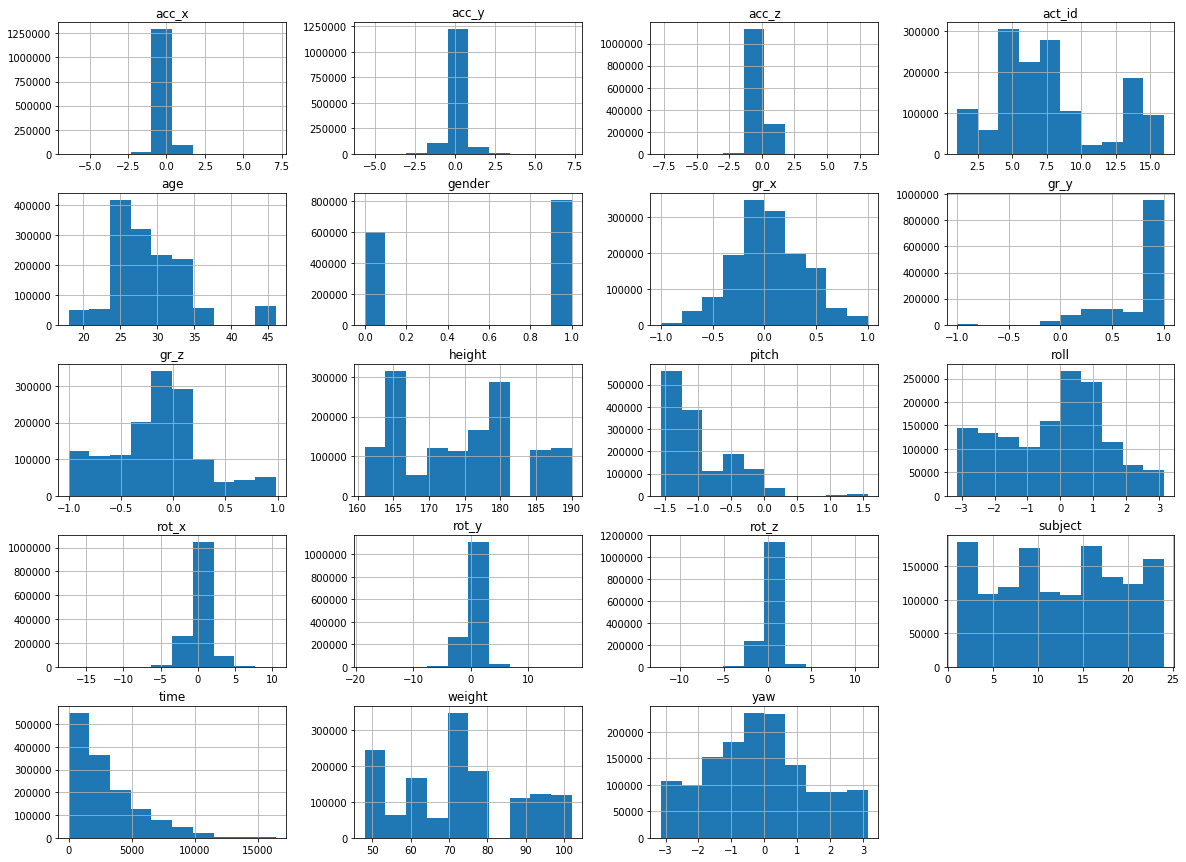

In [33]:
df.hist(figsize=(20,15))
plt.show()

We can see from the histograms that `gr_y` and `pitch` are tail heavy. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will transform latter these attributes to  have a more bell-shaped distribution.

In order to make Data visualization simplier, I will  use mean values of each time step according to gender, activity length, and activity.

In [34]:
numerical = ("roll", "pitch", "yaw", "gr_x", "gr_y", "gr_z","rot_x", "rot_y", "rot_z", "acc_x", "acc_y", "acc_z")

I amb going to reshape of the DataFrame grouping the numerical values by its mean, and sliced by `time`, `activity`, `gender` and length of the activity, `label_len`.

In [35]:
#long = df["label_len"].filter("long", df)
df = df.reset_index()
summary_mean = df.groupby(by= ["time","activity", "gender", "label_len"])[numerical].mean()

This is the result:

In [36]:
summary_mean.tail(5)

,,,,roll,pitch,yaw,gr_x,gr_y,gr_z,rot_x,rot_y,rot_z,acc_x,acc_y,acc_z
time,activity,gender,label_len,,,,,,,,,,,,
16419,std,0,long,-1.697280,-1.163849,1.084489,-0.392640,0.918333,0.049929,0.016522,-0.041271,-0.001652,-0.052688,0.010057,0.065031
16420,std,0,long,-1.696374,-1.164667,1.085189,-0.391940,0.918657,0.049479,0.024057,0.034094,0.059193,-0.119367,0.028502,0.045308
16421,std,0,long,-1.699372,-1.168712,1.085431,-0.388101,0.920247,0.050177,0.054160,-0.231900,0.217841,0.081400,-0.014669,0.102747
16422,std,0,long,-1.697491,-1.170770,1.090484,-0.386315,0.921051,0.049208,0.134297,-0.149422,0.035629,0.027917,-0.036133,0.073565
16423,std,0,long,-1.696307,-1.170511,1.095857,-0.386610,0.920950,0.048780,0.074797,-0.178704,-0.049138,0.003065,-0.012442,0.061221


Saving this new table will help us to take a shortcut of this kernel.

In [37]:
summary_mean.to_csv("summary_mean.csv", index = True, header = True)

The `melt` method will have us to reshape the data to help us with the plotting. I will create a `metric` column with the value of the `variable` of interest.

In [38]:
df2 =pd.melt(summary_mean.reset_index(), 
             id_vars = ["time", "activity", "gender", "label_len"],
             value_vars = numerical, 
             value_name = "metric" )

In [39]:
df2.head()

,time,activity,gender,label_len,variable,metric
0,0,dws,0,long,roll,-0.052483
1,0,dws,0,short,roll,0.195550
2,0,dws,1,long,roll,0.119389
3,0,dws,1,short,roll,-0.595158
4,0,jog,0,long,roll,-0.944827


Let's save again the result.

In [40]:
df2.to_csv("df2.csv", header = True)

I am going to mix programming languages in this kernel as R is a much suitable tool for Data Visualization. For that purpose I am using `rpy2` package.

In [41]:
%load_ext rpy2.ipython

In [42]:
%%R
# import R packages if they are not installed
list.of.packages <- c("ggplot2", "tidyr", "dplyr", "gridExtra")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "http://cran.us.r-project.org")

In [43]:
%%R
#Load Packages
library(ggplot2)
library(tidyr)
library(dplyr)
library(gridExtra)

In [ ]:
%%R -i df2

options(repr.plot.width = 3, repr.plot.height=2)

grid1 <- df2 %>% filter(label_len == "long") %>% ggplot(aes(time, metric, col=variable)) + 
geom_line() + facet_grid(activity~gender, scales = "free")+ ggtitle("Long Activities | Mean") 

grid2 <- df2 %>% filter(label_len == "short") %>% ggplot(aes(time, metric, col=variable)) + 
geom_line() + facet_grid(activity~gender, scales = "free")+ ggtitle("Short Activities | Mean") 

grid.arrange(grid1, grid2)

Let's focus a bit our visualization. I am going to plot the mean of the metrics for **`long`** **`ups`** and **`short`** **`ups`** for both genders.

In [ ]:
%%R
ups_0<- df2 %>% filter(label_len == "long", activity =="ups", gender ==0) %>% 
ggplot(aes(time, metric, col=variable)) + geom_line()+ ggtitle("Upstairs (Long) | Female")

ups_1<-df2 %>% filter(label_len == "long", activity == "ups", gender ==1) %>% 
ggplot(aes(time, metric, col=variable)) + geom_line()+ ggtitle("Upstairs (Long) | Male")

grid.arrange(ups_0, ups_1)

### Rotation

In [ ]:
%%R
#Rotation
rotation <- c("rot_x", "rot_y", "rot_z")
rot_0<- df2 %>% filter(label_len == "long", activity =="ups", variable == rotation, gender ==0) %>% 
ggplot(aes(time, metric, col=variable)) + geom_line() + ggtitle("Upstairs (Long) | Female")+ labs(y="Rotation")
rot_1<-df2 %>% filter(label_len == "long", activity == "ups", variable == rotation, gender ==1) %>% 
ggplot(aes(time, metric, col=variable)) + geom_line() + ggtitle("Upstairs (Long) | Male")+ labs(y="Rotation")

#Gravity
gravity <- c("gr_x", "gr_y", "gr_z")
gr_0<- df2 %>% filter(label_len == "long", activity =="ups", variable == gravity, gender ==0) %>% 
ggplot(aes(time, metric, col=variable)) + geom_line() + ggtitle("Upstairs (Long) | Female") + 
labs(y="Gravity")
gr_1<-df2 %>% filter(label_len == "long", activity == "ups", variable == gravity, gender ==1) %>% 
ggplot(aes(time, metric, col=variable)) + geom_line() + ggtitle("Upstairs (Long) | Male") + labs(y="Gravity")

grid.arrange(rot_0, rot_1, gr_0, gr_1)

### Accuracy

In [ ]:
%%R

#Accuracy
accuracy <- c("acc_x", "acc_y", "acc_z")
acc_0<- df2 %>% filter(label_len == "long", activity =="ups", variable == accuracy, gender ==0) %>% 
ggplot(aes(time, metric, col=variable)) + geom_line() + ggtitle("Upstairs (Long) | Female") + labs(y="Accuracy")
acc_1<-df2 %>% filter(label_len == "long", activity == "ups", variable == accuracy, gender ==1) %>% 
ggplot(aes(time, metric, col=variable)) + geom_line() + ggtitle("Upstairs (Long) | Male") + labs(y="Accuracy")

#Inclinometer: Pitch, roll, yaw
inclinometer <- c("pitch", "roll", "yaw")
inc_0<- df2 %>% filter(label_len == "long", activity =="ups", variable == inclinometer, gender ==0) %>% 
ggplot(aes(time, metric, col=variable)) + geom_line() + ggtitle("Upstairs (Long) | Female") + labs(y="Inclinometer")
inc_1<-df2 %>% filter(label_len == "long", activity == "ups", variable == inclinometer, gender ==1) %>% 
ggplot(aes(time, metric, col=variable)) + geom_line() + ggtitle("Upstairs (Long) | Male")+ labs(y="Inclinometer")

grid.arrange(acc_0, acc_1, inc_0, inc_1)

Finally, we want to provide an easy way to recreate our working environment exporting the 'requirements' text file. 

I am going to use the `long` activities as `train set` and the short ones as a `test set`

In [ ]:
! pip freeze > requirements.txt